In [6]:
import ee
import leafmap.foliumap as leafmap
import leafmap.maplibregl as leafmap
ee.Authenticate()
ee.Initialize()


In [8]:
m = leafmap.Map(projection="globe", sidebar_visible=True)
m.add_basemap("USGS.Imagery")
m.add_alphaearth_gui()
m

Container(children=[Row(children=[Col(children=[Col(children=[Map(calls=[['addControl', ('NavigationControl', …

In [9]:
m = leafmap.Map(projection="globe", sidebar_visible=True)
m.add_basemap("USGS.Imagery")
m

Container(children=[Row(children=[Col(children=[Col(children=[Map(calls=[['addControl', ('NavigationControl', …

In [15]:
lon = -121.8036
lat = 39.0372
m.set_center(lon, lat, zoom=12)
point = ee.Geometry.Point(lon, lat)
dataset = ee.ImageCollection("GOOGLE/SATELLITE_EMBEDDING/V1/ANNUAL")

image1 = dataset.filterDate("2017-01-01", "2018-01-01").filterBounds(point).first()
image2 = dataset.filterDate("2024-01-01", "2025-01-01").filterBounds(point).first()


vis_params = {"min": -0.3, "max": 0.3, "bands": ["A01", "A16", "A09"]}
m.add_ee_layer(image1, vis_params, name="Year 1 embeddings")
m.add_ee_layer(image2, vis_params, name="Year 2 embeddings")


dot_prod = image1.multiply(image2).reduce(ee.Reducer.sum())
vis_params = {"min": 0, "max": 1, "palette": ["white", "black"]}
m.add_ee_layer(dot_prod, vis_params, name="Similarity")
m

Container(children=[Row(children=[Col(children=[Col(children=[Map(calls=[['addControl', ('NavigationControl', …

In [ ]:
# Example: 84.2–85.2E, 25.0–26.0N (change to your region)
roi = ee.Geometry.Rectangle([84.2, 25.0, 85.2, 26.0])
year = 2024
col  = ee.ImageCollection("GOOGLE/SATELLITE_EMBEDDING/V1/ANNUAL") \
          .filterDate(f"{year}-01-01", f"{year+1}-01-01")



In [21]:
# Define a point for your area of interest
aoi_point = ee.Geometry.Point(-121.8036, 39.0372)
# Select the image for a specific year, for example 2024
image = dataset.filterDate('2024-01-01', '2025-01-01').first()

# Export the image for your defined AOI
leafmap.ee_export_image(
    image=image,
    filename="alphaearth_data.tif",
    region=aoi_point.buffer(1000).bounds(),  # Export a 1km buffer around the point
    scale=10  # 10-meter resolution
)


AttributeError: module 'leafmap.maplibregl' has no attribute 'ee_export_image'

In [27]:
# pip install earthengine-api requests rasterio
import ee, requests, rasterio, io

# --- 0) Auth/init (first run will open browser) ---
try:
    ee.Initialize()
except Exception:
    ee.Authenticate()
    ee.Initialize()


# "geometry": { "type": "Polygon", "coordinates": [ [ [ 89.096616678013973, 24.011428555344338 ], [ 89.096616678013973, 24.023016822509479 ], [ 89.085028410848821, 24.023016822509479 ], [ 89.085028410848821, 24.011428555344338 ], [ 89.096616678013973, 24.011428555344338 ] ] ] } },
# --- 1) Your polygon (lon, lat) WGS84 ---
coords = [[
    [ 89.096616678013973, 24.011428555344338 ], [ 89.096616678013973, 24.023016822509479 ], [ 89.085028410848821, 24.023016822509479 ], [ 89.085028410848821, 24.011428555344338 ], [ 89.096616678013973, 24.011428555344338 ]  # closed ring
]]
roi = ee.Geometry.Polygon(coords)

# --- 2) Pick CRS (UTM zone for ~77E, 29N is EPSG:32643) ---
epsg = "EPSG:32643"

# --- 3) Get 2024 AlphaEarth (64 bands A00..A63) ---
img = (ee.ImageCollection("GOOGLE/SATELLITE_EMBEDDING/V1/ANNUAL")
       .filterDate('2024-01-01', '2025-01-01')
       .mosaic()
       .toFloat())

# --- 4) Direct download as a multiband GeoTIFF ---
url = img.getDownloadURL({
    'region': roi,
    'scale': 10,            # 10 m
    'crs': epsg,            # align to UTM 43N
    'filePerBand': False,   # one 64-band file
    'format': 'GEO_TIFF'
})
print("Download URL:", url)

tif_bytes = requests.get(url, timeout=600).content
out_path = "AEF_2024_poly_utm43n-17brick-bangladesh.tif"
with open(out_path, "wb") as f:
    f.write(tif_bytes)
print("Saved:", out_path)

# --- 5) Quick check ---
with rasterio.open(out_path) as src:
    print("Bands x H x W:", src.count, src.height, src.width)  # expect 64 × ~110–130 px per side
    print("CRS:", src.crs, "Resolution:", src.res)             # ~ (10.0, 10.0)

Download URL: https://earthengine.googleapis.com/v1/projects/819031523602/thumbnails/efb7a7b669f87ab32219b4a596fca823-dbe0d5463762865e3b13916a024e3f98:getPixels


Saved: AEF_2024_poly_utm43n-17brick-bangladesh.tif
Bands x H x W: 64 144 135
CRS: EPSG:32643 Resolution: (10.0, 10.0)


Loaded /home/rishabh.mondal/Brick-Kilns-project/ijcai_2025_kilns/Foundation-Models/alphaearth/AEF_2024_poly_utm43n-17brick-bangladesh.tif
Bands x H x W: (64, 144, 135)  |  CRS: EPSG:32643  |  Resolution: (10.0, 10.0) m


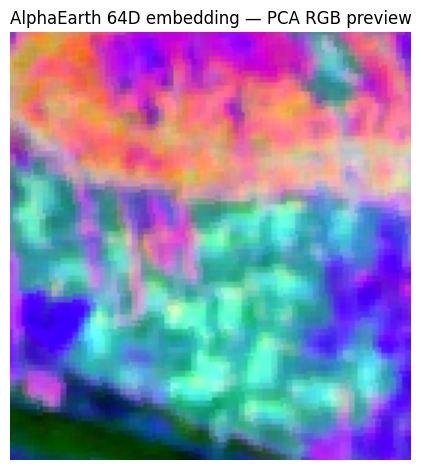

Saved preview → /home/rishabh.mondal/Brick-Kilns-project/ijcai_2025_kilns/Foundation-Models/alphaearth/AEF_2024_poly_utm43n-17brick-bangladesh_PCARGB.png


In [28]:
# Visualize AlphaEarth 64-band embedding as PCA-RGB
# pip install rasterio matplotlib numpy

import os
import numpy as np
import rasterio
import matplotlib.pyplot as plt

tif_path = "/home/rishabh.mondal/Brick-Kilns-project/ijcai_2025_kilns/Foundation-Models/alphaearth/AEF_2024_poly_utm43n-17brick-bangladesh.tif"

with rasterio.open(tif_path) as src:
    arr = src.read(out_dtype="float32")  # (64, H, W)
    crs = src.crs
    res = src.res
    print(f"Loaded {tif_path}")
    print(f"Bands x H x W: {arr.shape}  |  CRS: {crs}  |  Resolution: {res} m")

# Handle NaNs/NoData
if np.ma.isMaskedArray(arr):
    arr = arr.filled(np.nan)

# Flatten to (N, 64), subtract mean (ignore NaNs)
B, H, W = arr.shape
X = arr.reshape(B, -1).T  # (N, 64)
band_means = np.nanmean(X, axis=0, keepdims=True)
Xc = X - band_means

# Replace any remaining NaNs with 0 after centering
Xc = np.nan_to_num(Xc, nan=0.0)

# PCA via SVD: Xc = U S Vt  -> top 3 components in Vt[:3]
# For small chips this is fast and avoids sklearn dependency
U, S, Vt = np.linalg.svd(Xc, full_matrices=False)
Vt3 = Vt[:3, :]                               # (3, 64)
Y3 = (Xc @ Vt3.T).reshape(H, W, 3)            # (H, W, 3)

# Min–max per channel to [0,1] (robust clip to 2nd–98th percentiles to avoid outliers)
viz = np.zeros_like(Y3)
for c in range(3):
    chan = Y3[..., c]
    lo, hi = np.percentile(chan[~np.isnan(chan)], [2, 98]) if np.isfinite(chan).any() else (0, 1)
    if hi - lo < 1e-6:
        viz[..., c] = 0.5
    else:
        chan = np.clip(chan, lo, hi)
        viz[..., c] = (chan - lo) / (hi - lo)

# Save PNG next to the TIFF
png_path = os.path.splitext(tif_path)[0] + "_PCARGB.png"

plt.figure()
plt.imshow(viz, origin="upper")
plt.axis("off")
plt.title("AlphaEarth 64D embedding — PCA RGB preview")
plt.tight_layout()
plt.savefig(png_path, dpi=200, bbox_inches="tight", pad_inches=0)
plt.show()

print(f"Saved preview → {png_path}")

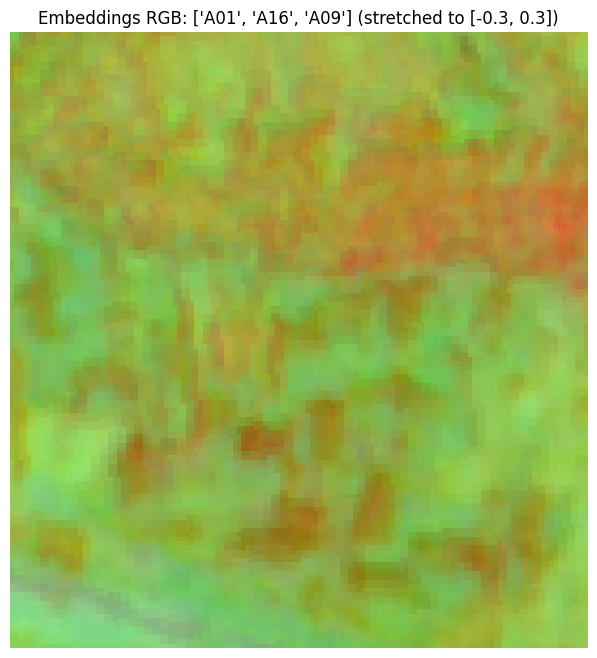

Saved: AEF_A01_A16_A09_preview.png


In [29]:
# --- Static RGB preview with rasterio + matplotlib ---
import rasterio
import numpy as np
import matplotlib.pyplot as plt
from rasterio.enums import Resampling

tif_path = "/home/rishabh.mondal/Brick-Kilns-project/ijcai_2025_kilns/Foundation-Models/alphaearth/AEF_2024_poly_utm43n-17brick-bangladesh.tif"
band_names = ["A01", "A16", "A09"]  # R, G, B
vmin, vmax = -0.3, 0.3              # typical embedding range

def name_to_index(ds, name: str) -> int:
    """Convert a band name like 'A16' to 1-based band index."""
    # If descriptions exist and match names exactly
    if ds.descriptions and name in ds.descriptions:
        return ds.descriptions.index(name) + 1
    # Fallback: interpret 'A01'..'A64' as 1..64
    if name.lower().startswith("a") and name[1:].isdigit():
        idx = int(name[1:])
        if 1 <= idx <= ds.count:
            return idx
    raise ValueError(f"Band '{name}' not found in {tif_path}")

def normalize(arr, lo, hi):
    arr = np.clip(arr, lo, hi)
    return (arr - lo) / (hi - lo + 1e-12)

with rasterio.open(tif_path) as ds:
    idxs = [name_to_index(ds, n) for n in band_names]

    # Light downsample for fast preview (~1k px max)
    scale = max(ds.width, ds.height) / 1024
    read_kwargs = {}
    if scale > 1:
        out_h, out_w = int(ds.height / scale), int(ds.width / scale)
        read_kwargs = {"out_shape": (len(idxs), out_h, out_w), "resampling": Resampling.bilinear}

    cube = ds.read(indexes=idxs, **read_kwargs).astype(np.float32)

rgb = np.stack([
    normalize(cube[0], vmin, vmax),
    normalize(cube[1], vmin, vmax),
    normalize(cube[2], vmin, vmax),
], axis=-1)

plt.figure(figsize=(8, 8))
plt.imshow(rgb)
plt.axis("off")
plt.title(f"Embeddings RGB: {band_names} (stretched to [{vmin}, {vmax}])")
plt.show()

# Optional: save preview
plt.imsave("AEF_A01_A16_A09_preview.png", rgb)
print("Saved: AEF_A01_A16_A09_preview.png")

Loaded /home/rishabh.mondal/Brick-Kilns-project/ijcai_2025_kilns/Foundation-Models/alphaearth/AEF_2024_poly_utm43n-17brick-bangladesh.tif
Bands x H x W: (64, 144, 135)  |  CRS: EPSG:32643  |  Resolution: (10.0, 10.0) m
Saved: /home/rishabh.mondal/Brick-Kilns-project/ijcai_2025_kilns/Foundation-Models/alphaearth/AEF_2024_poly_utm43n-17brick-bangladesh_A01_A16_A09_rgb.png
Saved: /home/rishabh.mondal/Brick-Kilns-project/ijcai_2025_kilns/Foundation-Models/alphaearth/AEF_2024_poly_utm43n-17brick-bangladesh_A01_A16_A09_bands.png


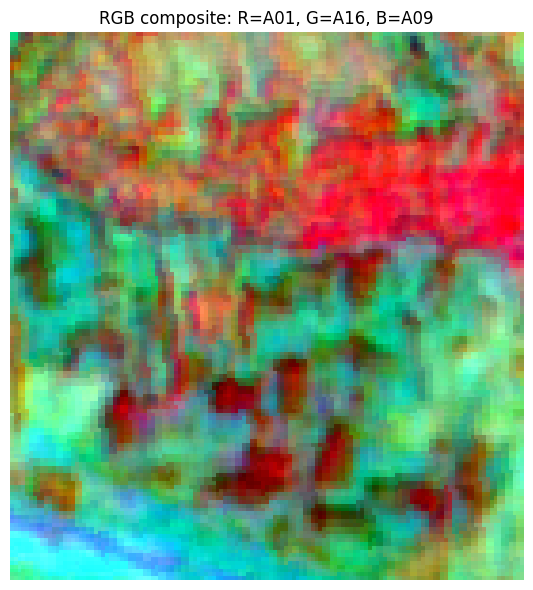

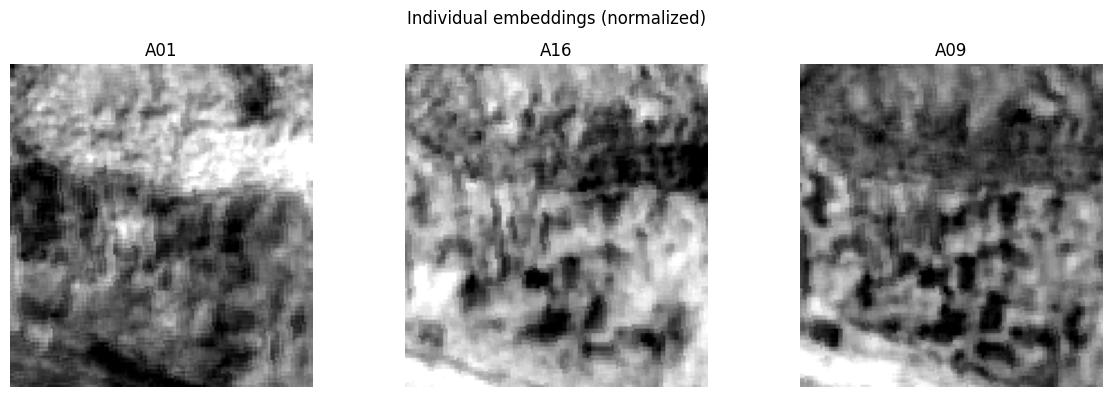

In [33]:
# Visualize 3 embedding bands from a 64-band AlphaEarth .tif
# R= A01, G= A16, B= A09, with robust min–max scaling

from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
import rasterio as rio

tif_path = "/home/rishabh.mondal/Brick-Kilns-project/ijcai_2025_kilns/Foundation-Models/alphaearth/AEF_2024_poly_utm43n-17brick-bangladesh.tif"
band_names = ["A01", "A16", "A09"]  # R, G, B

def a_name_to_index(a_name: str) -> int:
    """
    Convert 'A01'..'A64' -> 1..64 (rasterio 1-based band index).
    """
    a_name = a_name.strip().upper()
    if not (len(a_name) == 3 and a_name[0] == "A" and a_name[1:].isdigit()):
        raise ValueError(f"Invalid band name: {a_name}. Expected like 'A01'.")
    idx = int(a_name[1:])
    if not (1 <= idx <= 64):
        raise ValueError(f"Band index out of range [1,64]: {idx}")
    return idx

def robust_norm(arr: np.ndarray, pmin=2, pmax=98) -> np.ndarray:
    """
    Percentile-based normalization to [0,1] with outlier clipping.
    Works even if there are NaNs or infs.
    """
    finite = np.isfinite(arr)
    if not np.any(finite):
        return np.zeros_like(arr, dtype=np.float32)
    lo, hi = np.percentile(arr[finite], [pmin, pmax])
    if hi <= lo:
        # avoid divide-by-zero if constant
        return np.zeros_like(arr, dtype=np.float32)
    arr = (arr - lo) / (hi - lo)
    return np.clip(arr, 0, 1).astype(np.float32)

# --- Load and read the requested bands ---
with rio.open(tif_path) as ds:
    print(f"Loaded {tif_path}")
    print(f"Bands x H x W: ({ds.count}, {ds.height}, {ds.width})  |  CRS: {ds.crs}  |  Resolution: {ds.res} m")

    idxs = [a_name_to_index(n) for n in band_names]        # e.g., [1,16,9]
    stack = ds.read(indexes=idxs)                           # shape = (3, H, W), dtype per file

# Normalize each band separately (good for embeddings)
r = robust_norm(stack[0])
g = robust_norm(stack[1])
b = robust_norm(stack[2])

rgb = np.stack([r, g, b], axis=-1)                         # (H, W, 3), float32 in [0,1]

# --- Plot & save ---
out_base = str(Path(tif_path).with_suffix(""))
rgb_png   = f"{out_base}_{band_names[0]}_{band_names[1]}_{band_names[2]}_rgb.png"
bands_png = f"{out_base}_{band_names[0]}_{band_names[1]}_{band_names[2]}_bands.png"

plt.figure(figsize=(6, 6))
plt.imshow(rgb)
plt.title(f"RGB composite: R={band_names[0]}, G={band_names[1]}, B={band_names[2]}")
plt.axis("off")
plt.tight_layout()
plt.savefig(rgb_png, dpi=200, bbox_inches="tight")
print("Saved:", rgb_png)

fig, axes = plt.subplots(1, 3, figsize=(12, 4))
for ax, band, name in zip(axes, [r, g, b], band_names):
    im = ax.imshow(band, cmap="gray")
    ax.set_title(name)
    ax.axis("off")
fig.suptitle("Individual embeddings (normalized)")
plt.tight_layout()
plt.savefig(bands_png, dpi=200, bbox_inches="tight")
print("Saved:", bands_png)

Loaded /home/rishabh.mondal/Brick-Kilns-project/ijcai_2025_kilns/Foundation-Models/alphaearth/AEF_2024_poly_utm43n-17brick-bangladesh.tif
Bands x H x W: (64, 144, 135)  |  CRS: EPSG:32643  |  Resolution: (10.0, 10.0) m
A01: min=-0.062991, max=0.206936, mean=0.046770, dtype=float32
A16: min=-0.071111, max=0.236463, mean=0.104804, dtype=float32
A09: min=-0.267958, max=0.029773, mean=-0.137632, dtype=float32
Saved: /home/rishabh.mondal/Brick-Kilns-project/ijcai_2025_kilns/Foundation-Models/alphaearth/AEF_2024_poly_utm43n-17brick-bangladesh_A01_A16_A09_RAW_-1to1_bands.png


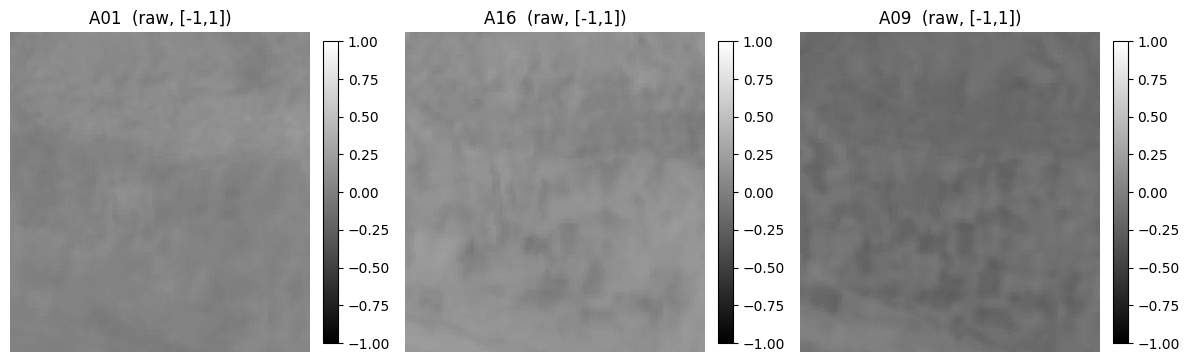

In [32]:
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
import rasterio as rio

tif_path = "/home/rishabh.mondal/Brick-Kilns-project/ijcai_2025_kilns/Foundation-Models/alphaearth/AEF_2024_poly_utm43n-17brick-bangladesh.tif"
band_names = ["A01", "A16", "A09"]  # requested bands

def a_name_to_index(a_name: str) -> int:
    a_name = a_name.strip().upper()
    if not (len(a_name) == 3 and a_name[0] == "A" and a_name[1:].isdigit()):
        raise ValueError(f"Invalid band name: {a_name}. Expected like 'A01'.")
    idx = int(a_name[1:])
    if not (1 <= idx <= 64):
        raise ValueError(f"Band index out of range [1,64]: {idx}")
    return idx

with rio.open(tif_path) as ds:
    print(f"Loaded {tif_path}")
    print(f"Bands x H x W: ({ds.count}, {ds.height}, {ds.width})  |  CRS: {ds.crs}  |  Resolution: {ds.res} m")
    idxs = [a_name_to_index(n) for n in band_names]
    stack = ds.read(indexes=idxs)  # (3, H, W), raw float likely in [-1, 1]

# Fixed raw range for display (no data-driven normalization)
VMIN, VMAX = -1.0, 1.0

# Quick stats (helps catch any unexpected range)
for i, name in enumerate(band_names):
    arr = stack[i]
    print(f"{name}: min={np.nanmin(arr):.6f}, max={np.nanmax(arr):.6f}, mean={np.nanmean(arr):.6f}, dtype={arr.dtype}")

# Per-band RAW visuals with fixed scale [-1, 1]
out_base = str(Path(tif_path).with_suffix(""))
bands_png = f"{out_base}_{band_names[0]}_{band_names[1]}_{band_names[2]}_RAW_-1to1_bands.png"

fig, axes = plt.subplots(1, 3, figsize=(12, 4))
for ax, band, name in zip(axes, [stack[0], stack[1], stack[2]], band_names):
    im = ax.imshow(band, cmap="gray", vmin=VMIN, vmax=VMAX)  # fixed, no auto-scaling
    ax.set_title(f"{name}  (raw, [-1,1])")
    ax.axis("off")
    plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
plt.tight_layout()
plt.savefig(bands_png, dpi=200, bbox_inches="tight")
print("Saved:", bands_png)

# NOTE: RGB composite is intentionally skipped because raw [-1,1] values
# are not directly displayable as RGB without remapping to [0,1] or uint8.
# If you want an RGB quicklook, we can do a simple linear map: (x + 1) * 0.5.

In [34]:
import geemap
import rasterio as rio

tif_path = "/home/rishabh.mondal/Brick-Kilns-project/ijcai_2025_kilns/Foundation-Models/alphaearth/AEF_2024_poly_utm43n-17brick-bangladesh.tif"
band_names = ["A01", "A16", "A09"]  # R,G,B for composite
coords = [[
    [89.096616678013973, 24.011428555344338],
    [89.096616678013973, 24.023016822509479],
    [89.085028410848821, 24.023016822509479],
    [89.085028410848821, 24.011428555344338],
    [89.096616678013973, 24.011428555344338]
]]

# ensure closed ring (safety)
if coords[0][0] != coords[0][-1]:
    coords[0].append(coords[0][0])

# wrap as FeatureCollection with properties to avoid KeyError
roi_fc = {
    "type": "FeatureCollection",
    "features": [{
        "type": "Feature",
        "properties": {"name": "ROI"},
        "geometry": {"type": "Polygon", "coordinates": coords}
    }]
}

# compute center/bounds for map
lons = [xy[0] for xy in coords[0]]
lats = [xy[1] for xy in coords[0]]
min_lon, max_lon = min(lons), max(lons)
min_lat, max_lat = min(lats), max(lats)
center = ((min_lat + max_lat) / 2.0, (min_lon + max_lon) / 2.0)

m = geemap.Map(center=center, zoom=15)
m.add_basemap("SATELLITE")
m.add_basemap("HYBRID")

# add ROI (now has properties)
m.add_geojson(
    roi_fc,
    style={"color": "cyan", "fillColor": "#00000000", "weight": 2},
    layer_name="ROI polygon"
)

# add the raster layers with fixed raw domain [-1,1]
VMIN, VMAX = -1.0, 1.0

# single-band layers
def a_name_to_index(a): return int(a[1:])  # 'A01' -> 1 (rasterio is 1-based)
idxs = [a_name_to_index(b) for b in band_names]
for bname, bidx in zip(band_names, idxs):
    m.add_raster(
        tif_path,
        bands=[bidx],
        vmin=VMIN, vmax=VMAX,
        opacity=0.9,
        layer_name=f"{bname} (raw [-1,1])"
    )

# RGB composite with same fixed raw range (no percentile stretch)
m.add_raster(
    tif_path,
    bands=idxs,
    vmin=VMIN, vmax=VMAX,
    opacity=1.0,
    layer_name=f"RGB R={band_names[0]} G={band_names[1]} B={band_names[2]} (raw [-1,1])"
)

# zoom to ROI
m.fit_bounds([[min_lat, min_lon], [max_lat, max_lon]])
m

Map(center=[24.017222688926907, 89.0908225444314], controls=(WidgetControl(options=['position', 'transparent_b…

Loaded /home/rishabh.mondal/Brick-Kilns-project/ijcai_2025_kilns/Foundation-Models/alphaearth/AEF_2024_poly_utm43n-17brick-bangladesh.tif
Bands x H x W: (64, 144, 135) | CRS: EPSG:32643 | Resolution: (10.0, 10.0) m
Saved: /home/rishabh.mondal/Brick-Kilns-project/ijcai_2025_kilns/Foundation-Models/alphaearth/AEF_2024_poly_utm43n-17brick-bangladesh_A00-A63_RAW_-1to1_subplots.png


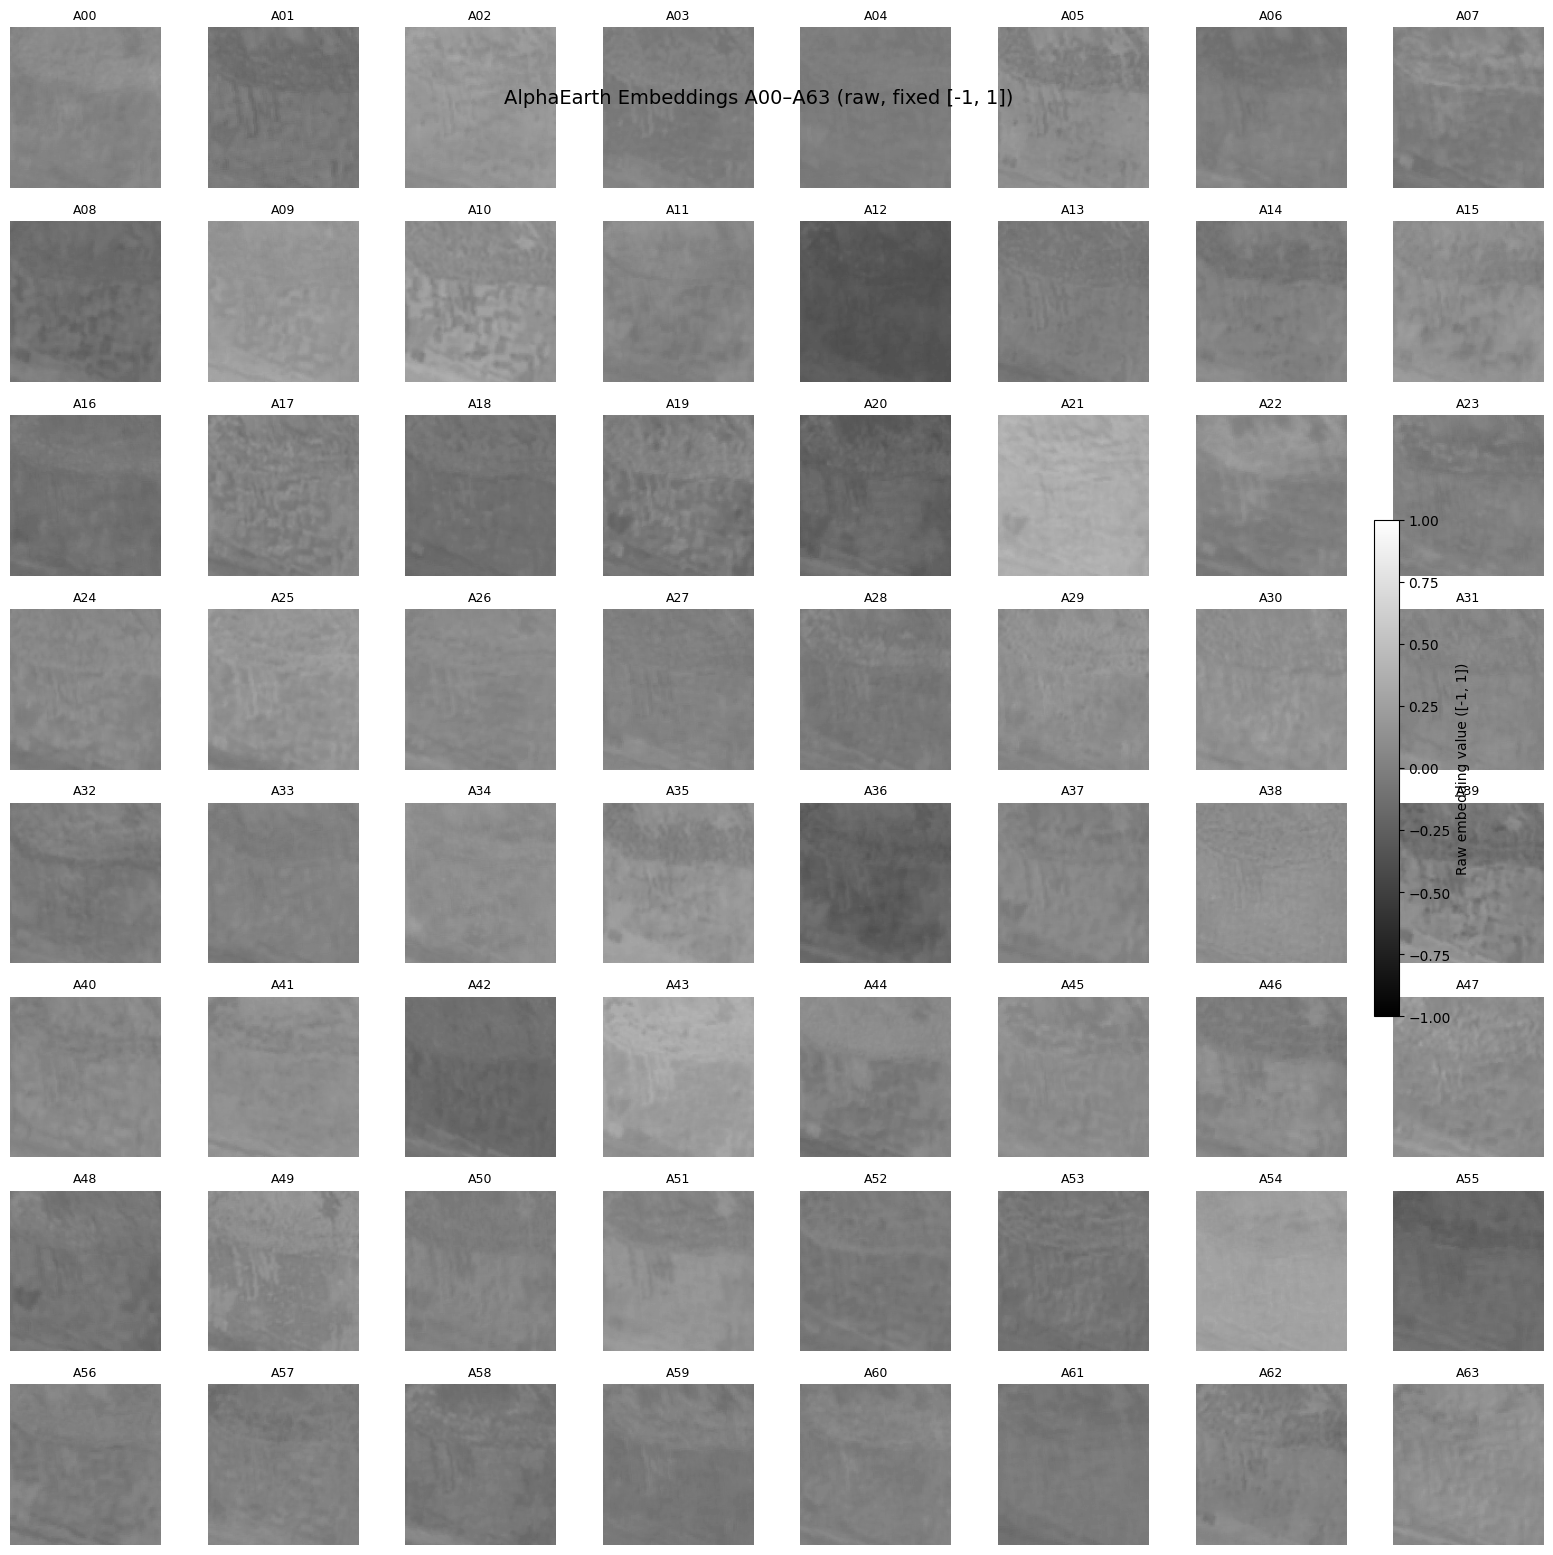

In [36]:
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import rasterio as rio

# --- Config ---
tif_path = "/home/rishabh.mondal/Brick-Kilns-project/ijcai_2025_kilns/Foundation-Models/alphaearth/AEF_2024_poly_utm43n-17brick-bangladesh.tif"
VMIN, VMAX = -1.0, 1.0       # fixed raw domain
ROWS, COLS = 8, 8            # 8x8 = 64 bands
SAVE_PDF = False             # set True if you also want a PDF

def idx_to_aname(i: int) -> str:
    """0->A00, 63->A63"""
    return f"A{i:02d}"

# --- Read all bands (rasterio is 1-based) ---
with rio.open(tif_path) as ds:
    print(f"Loaded {tif_path}")
    print(f"Bands x H x W: ({ds.count}, {ds.height}, {ds.width}) | CRS: {ds.crs} | Resolution: {ds.res} m")
    assert ds.count >= 64, f"Expected at least 64 bands, got {ds.count}"
    arr = ds.read(indexes=list(range(1, 65)))   # shape: (64, H, W), raw values

# --- Subplots 0..63 ---
fig, axes = plt.subplots(ROWS, COLS, figsize=(16, 16))
axes = axes.ravel()

for i in range(64):
    ax = axes[i]
    im = ax.imshow(arr[i], cmap="gray", vmin=VMIN, vmax=VMAX)
    ax.set_title(idx_to_aname(i), fontsize=9)
    ax.axis("off")

# Shared colorbar with fixed scale
sm = mpl.cm.ScalarMappable(norm=mpl.colors.Normalize(vmin=VMIN, vmax=VMAX), cmap="gray")
sm.set_array([])
cbar = fig.colorbar(sm, ax=axes.tolist(), fraction=0.02, pad=0.01)
cbar.set_label("Raw embedding value ([-1, 1])")

fig.suptitle("AlphaEarth Embeddings A00–A63 (raw, fixed [-1, 1])", y=0.92, fontsize=14)
plt.tight_layout()

out_base = str(Path(tif_path).with_suffix(""))
png_path = f"{out_base}_A00-A63_RAW_-1to1_subplots.png"
plt.savefig(png_path, dpi=250, bbox_inches="tight")
print("Saved:", png_path)

if SAVE_PDF:
    pdf_path = f"{out_base}_A00-A63_RAW_-1to1_subplots.pdf"
    plt.savefig(pdf_path, bbox_inches="tight")
    print("Saved:", pdf_path)

Loaded /home/rishabh.mondal/Brick-Kilns-project/ijcai_2025_kilns/Foundation-Models/alphaearth/AEF_2024_poly_utm43n-17brick-bangladesh.tif
Bands x H x W: (64, 144, 135) | CRS: EPSG:32643 | Resolution: (10.0, 10.0) m
Saved: /home/rishabh.mondal/Brick-Kilns-project/ijcai_2025_kilns/Foundation-Models/alphaearth/AEF_2024_poly_utm43n-17brick-bangladesh_A00-A63_ROBUST_2-98_subplots.png


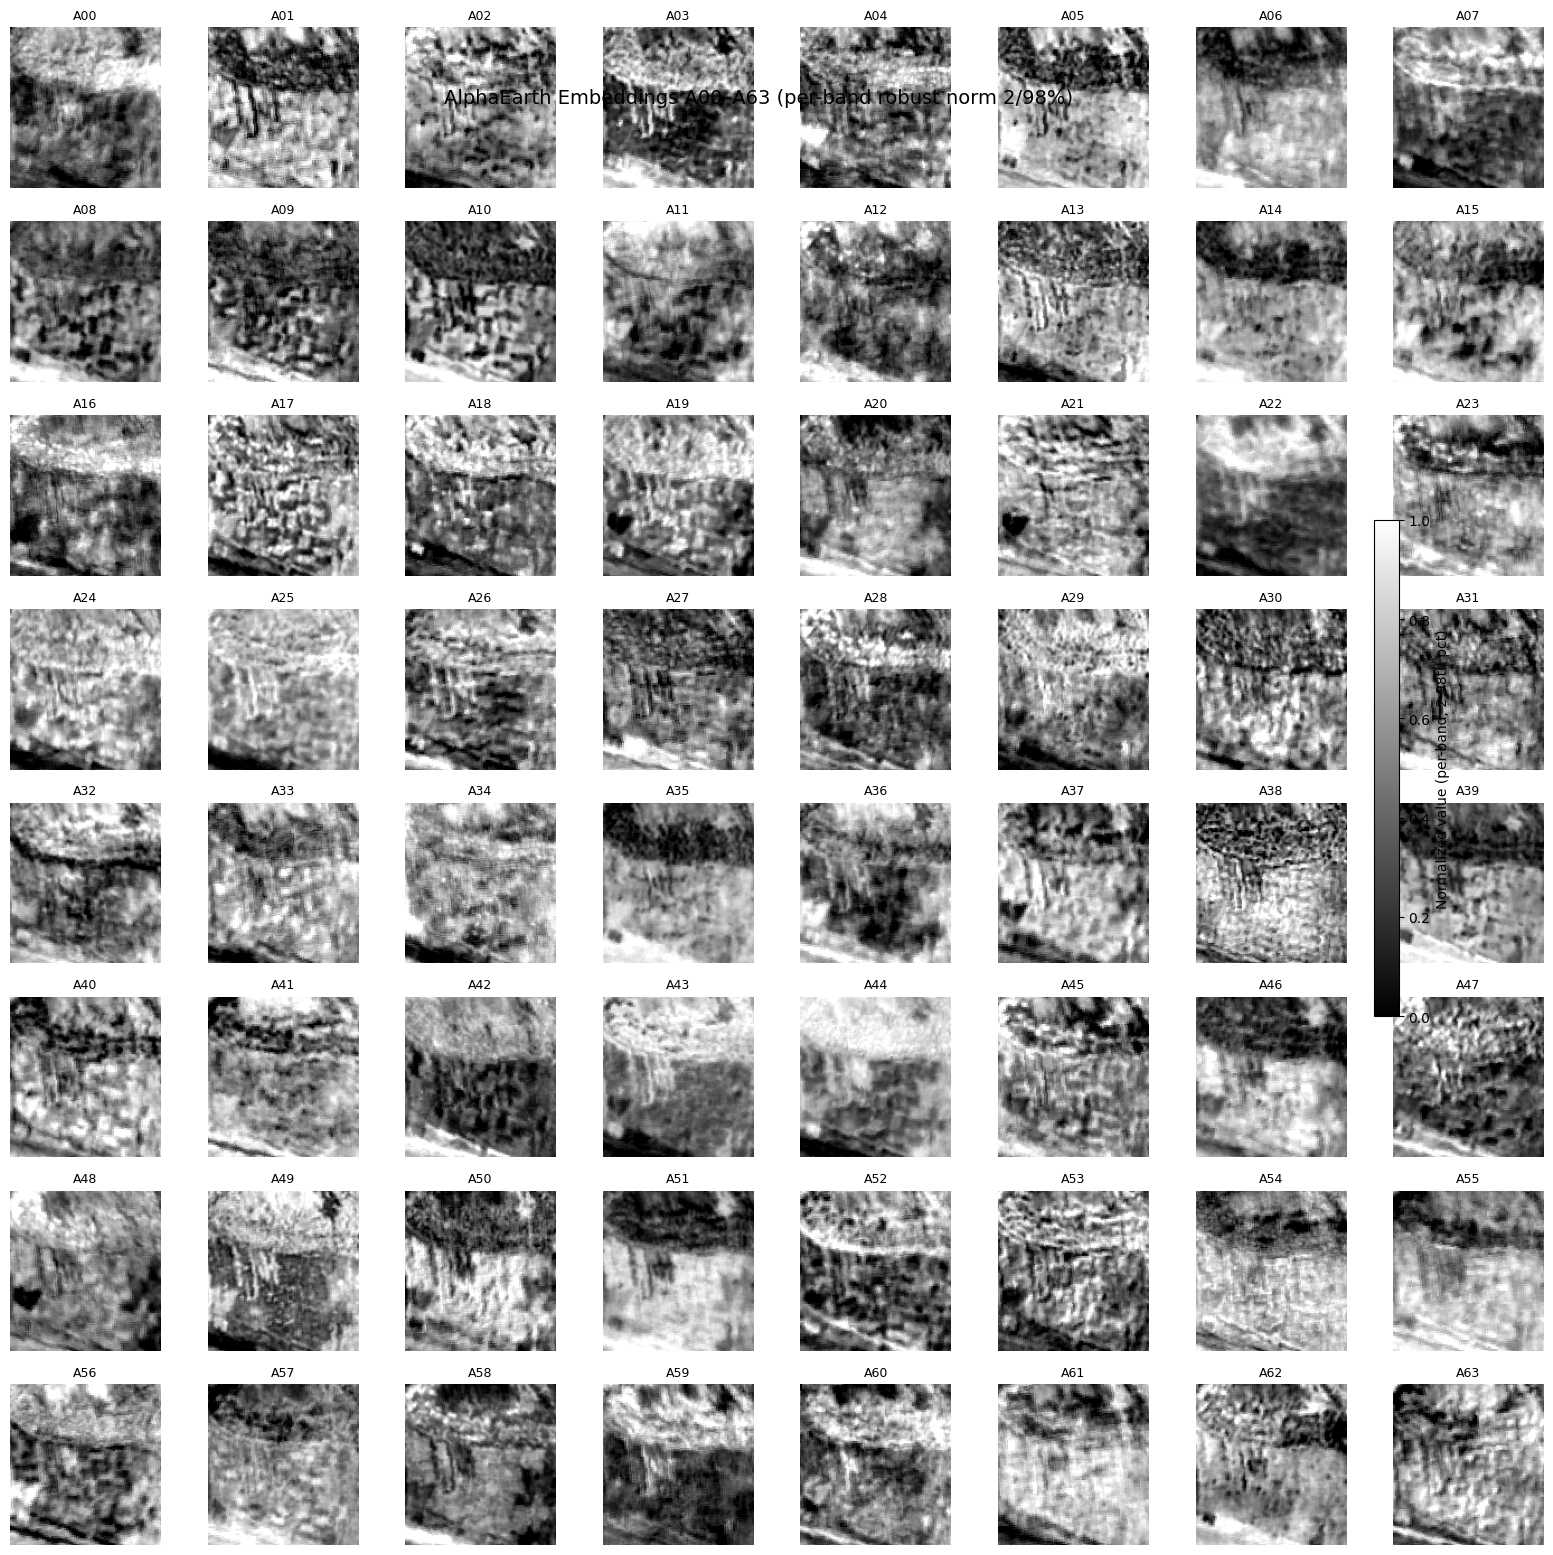

In [37]:
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import rasterio as rio

# --- Config ---
tif_path = "/home/rishabh.mondal/Brick-Kilns-project/ijcai_2025_kilns/Foundation-Models/alphaearth/AEF_2024_poly_utm43n-17brick-bangladesh.tif"
ROWS, COLS = 8, 8                 # 8x8 = 64
PMIN, PMAX = 2, 98                # robust per-band normalization percentiles
SAVE_PDF = False
SAVE_INDIVIDUAL = False           # per-band PNGs of the normalized panels

def idx_to_aname(i: int) -> str:
    return f"A{i:02d}"            # 0->A00, 63->A63

def robust_norm(arr: np.ndarray, pmin=2, pmax=98) -> np.ndarray:
    """Percentile-based per-band normalization to [0,1]."""
    finite = np.isfinite(arr)
    if not np.any(finite):
        return np.zeros_like(arr, dtype=np.float32)
    lo, hi = np.nanpercentile(arr[finite], [pmin, pmax])
    if not np.isfinite(lo) or not np.isfinite(hi) or hi <= lo:
        return np.zeros_like(arr, dtype=np.float32)
    arr = (arr - lo) / (hi - lo)
    return np.clip(arr, 0, 1).astype(np.float32)

# --- Read all 64 bands (rasterio is 1-based) ---
with rio.open(tif_path) as ds:
    print(f"Loaded {tif_path}")
    print(f"Bands x H x W: ({ds.count}, {ds.height}, {ds.width}) | CRS: {ds.crs} | Resolution: {ds.res} m")
    assert ds.count >= 64, f"Expected at least 64 bands, got {ds.count}"
    arr = ds.read(indexes=list(range(1, 65)))  # (64, H, W), raw

# --- Normalize each band independently ---
norm = np.empty_like(arr, dtype=np.float32)
for i in range(64):
    norm[i] = robust_norm(arr[i], PMIN, PMAX)

# --- Plot 8x8 subplots (normalized) ---
fig, axes = plt.subplots(ROWS, COLS, figsize=(16, 16))
axes = axes.ravel()

for i in range(64):
    ax = axes[i]
    im = ax.imshow(norm[i], cmap="gray", vmin=0.0, vmax=1.0)  # fixed [0,1] after normalization
    ax.set_title(idx_to_aname(i), fontsize=9)
    ax.axis("off")

# Shared colorbar in [0,1]
sm = mpl.cm.ScalarMappable(norm=mpl.colors.Normalize(vmin=0.0, vmax=1.0), cmap="gray")
sm.set_array([])
cbar = fig.colorbar(sm, ax=axes.tolist(), fraction=0.02, pad=0.01)
cbar.set_label(f"Normalized value (per-band, {PMIN}-{PMAX}th pct)")

fig.suptitle(f"AlphaEarth Embeddings A00–A63 (per-band robust norm {PMIN}/{PMAX}%)", y=0.92, fontsize=14)
plt.tight_layout()

out_base = str(Path(tif_path).with_suffix(""))
png_path = f"{out_base}_A00-A63_ROBUST_{PMIN}-{PMAX}_subplots.png"
plt.savefig(png_path, dpi=250, bbox_inches="tight")
print("Saved:", png_path)

if SAVE_PDF:
    pdf_path = f"{out_base}_A00-A63_ROBUST_{PMIN}-{PMAX}_subplots.pdf"
    plt.savefig(pdf_path, bbox_inches="tight")
    print("Saved:", pdf_path)

# --- (Optional) per-band normalized PNGs ---
if SAVE_INDIVIDUAL:
    out_dir = Path(out_base + f"_bands_norm_{PMIN}-{PMAX}")
    out_dir.mkdir(parents=True, exist_ok=True)
    for i in range(64):
        name = idx_to_aname(i)
        plt.imsave(out_dir / f"{name}_norm_{PMIN}-{PMAX}.png", norm[i], cmap="gray", vmin=0.0, vmax=1.0)
    print("Saved per-band PNGs to:", out_dir)

Loaded /home/rishabh.mondal/Brick-Kilns-project/ijcai_2025_kilns/Foundation-Models/alphaearth/AEF_2024_poly_utm43n-17brick-bangladesh.tif
Bands x H x W: (64, 144, 135) | CRS: EPSG:32643 | Resolution: (10.0, 10.0) m
Saved: /home/rishabh.mondal/Brick-Kilns-project/ijcai_2025_kilns/Foundation-Models/alphaearth/AEF_2024_poly_utm43n-17brick-bangladesh_A00-A63_UINT8_FIXED_-1to1_subplots.png


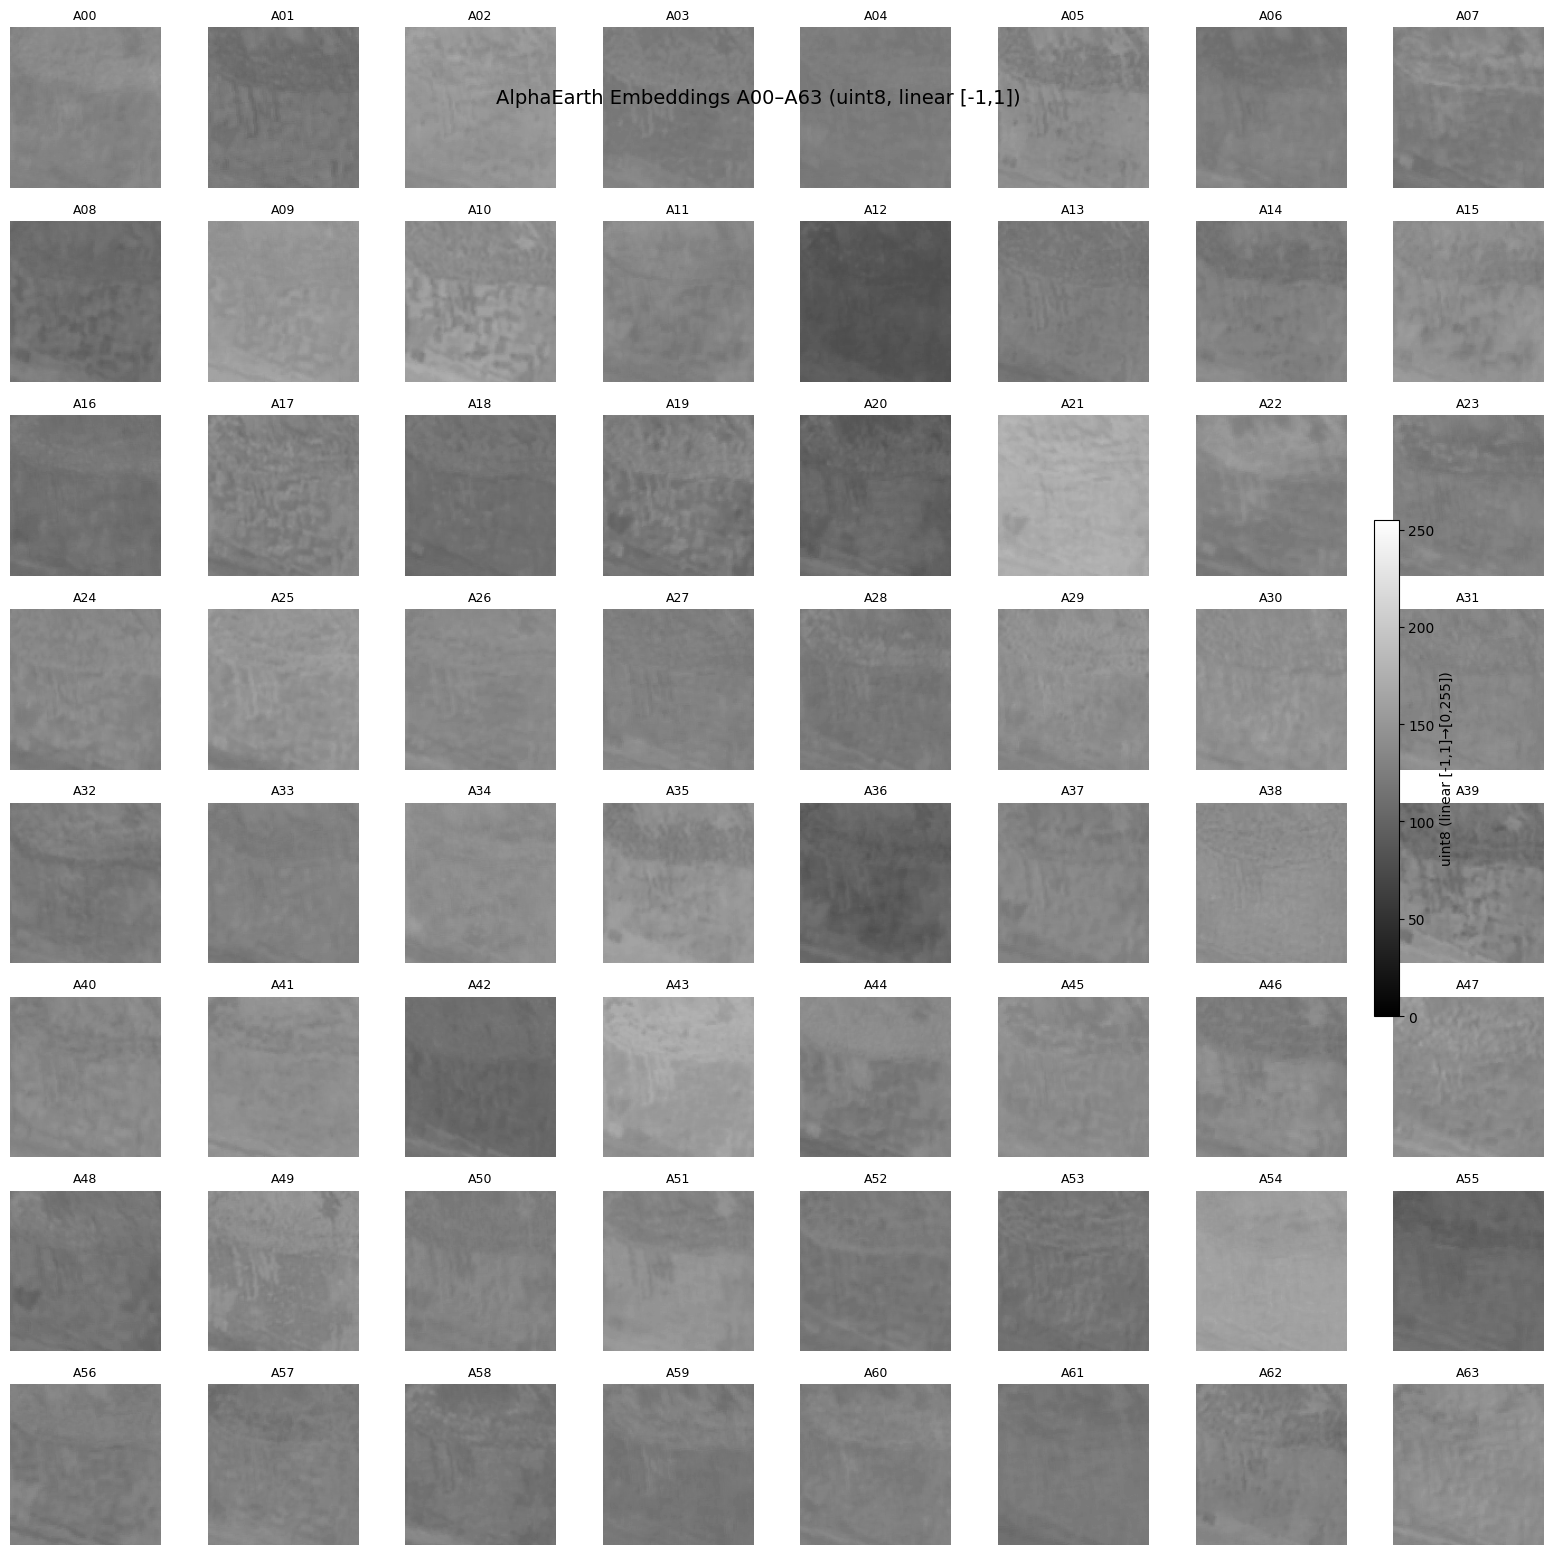

In [39]:
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import rasterio as rio

# --- Config ---
tif_path = "/home/rishabh.mondal/Brick-Kilns-project/ijcai_2025_kilns/Foundation-Models/alphaearth/AEF_2024_poly_utm43n-17brick-bangladesh.tif"
ROWS, COLS = 8, 8           # 8x8 = 64 bands
PMIN, PMAX = 2, 98          # robust per-band percentiles -> 0..255
SAVE_INDIVIDUAL = False     # also save each band as a separate PNG (uint8)

# Choose normalization mode:
USE_FIXED_MINUS1_TO1 = True
# True  -> map linearly from [-1, 1] to [0, 255] (same scale for all bands)
# False -> robust per-band percentile stretch (PMIN/PMAX) to [0, 255]

def idx_to_aname(i: int) -> str:
    return f"A{i:02d}"  # 0->A00, 63->A63

def robust_to_uint8(arr: np.ndarray, pmin=2, pmax=98) -> np.ndarray:
    """Per-band robust normalization to uint8 [0,255]."""
    finite = np.isfinite(arr)
    if not np.any(finite):
        return np.zeros_like(arr, dtype=np.uint8)
    lo, hi = np.nanpercentile(arr[finite], [pmin, pmax])
    if not np.isfinite(lo) or not np.isfinite(hi) or hi <= lo:
        return np.zeros_like(arr, dtype=np.uint8)
    out = (arr - lo) / (hi - lo)
    out = np.clip(out, 0, 1) * 255.0
    return out.astype(np.uint8)

def fixed_to_uint8_minus1_to1(arr: np.ndarray) -> np.ndarray:
    """Linear map from [-1,1] to [0,255] (same scale for every band)."""
    out = (arr + 1.0) * 0.5
    out = np.clip(out, 0, 1) * 255.0
    return out.astype(np.uint8)

# --- Read all 64 bands (rasterio is 1-based) ---
with rio.open(tif_path) as ds:
    print(f"Loaded {tif_path}")
    print(f"Bands x H x W: ({ds.count}, {ds.height}, {ds.width}) | CRS: {ds.crs} | Resolution: {ds.res} m")
    assert ds.count >= 64, f"Expected at least 64 bands, got {ds.count}"
    arr = ds.read(indexes=list(range(1, 65)))  # (64, H, W), raw values

# --- Normalize to uint8 ---
uint8_stack = np.empty_like(arr, dtype=np.uint8)
if USE_FIXED_MINUS1_TO1:
    for i in range(64):
        uint8_stack[i] = fixed_to_uint8_minus1_to1(arr[i])
else:
    for i in range(64):
        uint8_stack[i] = robust_to_uint8(arr[i], PMIN, PMAX)

# --- Plot 8x8 subplots (uint8) ---
fig, axes = plt.subplots(ROWS, COLS, figsize=(16, 16))
axes = axes.ravel()

for i in range(64):
    ax = axes[i]
    im = ax.imshow(uint8_stack[i], cmap="gray", vmin=0, vmax=255)
    ax.set_title(idx_to_aname(i), fontsize=9)
    ax.axis("off")

# Shared colorbar in [0,255]
sm = mpl.cm.ScalarMappable(norm=mpl.colors.Normalize(vmin=0, vmax=255), cmap="gray")
sm.set_array([])
cbar = fig.colorbar(sm, ax=axes.tolist(), fraction=0.02, pad=0.01)
label = (f"uint8 (robust {PMIN}-{PMAX}%)" if not USE_FIXED_MINUS1_TO1
         else "uint8 (linear [-1,1]→[0,255])")
cbar.set_label(label)

title = ("AlphaEarth Embeddings A00–A63 (uint8, robust "
         f"{PMIN}/{PMAX}%)" if not USE_FIXED_MINUS1_TO1
         else "AlphaEarth Embeddings A00–A63 (uint8, linear [-1,1])")
fig.suptitle(title, y=0.92, fontsize=14)
plt.tight_layout()

out_base = str(Path(tif_path).with_suffix(""))
suffix = (f"UINT8_ROBUST_{PMIN}-{PMAX}" if not USE_FIXED_MINUS1_TO1 else "UINT8_FIXED_-1to1")
png_path = f"{out_base}_A00-A63_{suffix}_subplots.png"
plt.savefig(png_path, dpi=250, bbox_inches="tight")
print("Saved:", png_path)

# --- (Optional) per-band PNGs ---
if SAVE_INDIVIDUAL:
    out_dir = Path(out_base + f"_bands_{suffix.lower()}")
    out_dir.mkdir(parents=True, exist_ok=True)
    for i in range(64):
        name = idx_to_aname(i)
        plt.imsave(out_dir / f"{name}_{suffix}.png", uint8_stack[i], cmap="gray", vmin=0, vmax=255)
    print("Saved per-band PNGs to:", out_dir)